In [1]:
import os
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [113]:
pd.set_option('display.max_rows', None)

In [28]:
from data_preprocess_util import str2percent, str2list, str2price
from data_statistics_util import cat_vs_label

In [52]:
listings = pd.read_csv("data" + os.sep + "listings.csv")
listings_detail = pd.read_csv("data" + os.sep + "listings_detail.csv")

/home/yangsi/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (43,61,62,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
reviews = pd.read_csv("data" + os.sep + "reviews.csv")
reviews_detail = pd.read_csv("data" + os.sep + "reviews_detail.csv")

In [7]:
# 为探寻哪些房源可以吸引人：开始设置label
# 共分为四类：
# （1）从来没有评价的房源
# （2）有评价的房源，但是所有客户都是单次访问
# （3）有评价的房源，且有一个顾客是多次访问
# （4）有评价且有多个顾客是多次访问的房源

In [62]:
re_cus_df = reviews_detail.groupby(["listing_id", "reviewer_id"])["id"].count()
re_cus_df = pd.DataFrame(re_cus_df)
re_cus_df.columns = ["count"]
re_cus_df = re_cus_df.reset_index()
once_cus_df = re_cus_df[re_cus_df["count"] == 1]
re_cus_df = re_cus_df[re_cus_df["count"] > 1]

In [63]:
# 该房源被至少一个顾客重复预定过
re_list_id = list(set(list(re_cus_df["listing_id"])))
print(len(re_list_id))

2033


In [10]:
# listings_detail[listings_detail["id"].isin(re_list_id)]

In [64]:
# 探寻被不只一个顾客重复预定的房源
list_rev_df = re_cus_df.groupby(["listing_id"])["reviewer_id"].count()
list_rev_df = pd.DataFrame(list_rev_df)
list_rev_df.columns = ["cus_num"]
g4_id_list = list_rev_df[list_rev_df["cus_num"] > 1].index.values
g3_id_list = list_rev_df[list_rev_df["cus_num"] == 1].index.values

In [65]:
# check length:
len(g3_id_list) + len(g4_id_list) == len(re_list_id)

True

In [66]:
listings_detail.loc[:, "label"] = np.nan
row_index = listings_detail[listings_detail["number_of_reviews"] == 0].index
listings_detail.loc[row_index, "label"] = 1

In [67]:
row_index = listings_detail[listings_detail["id"].isin(g3_id_list)].index
listings_detail.loc[row_index, "label"] = 3

row_index = listings_detail[listings_detail["id"].isin(g4_id_list)].index
listings_detail.loc[row_index, "label"] = 4

In [68]:
listings_detail["label"] = listings_detail["label"].fillna(2)

In [16]:
listings_detail["label"].value_counts()

2.0    15261
1.0    11158
3.0     1506
4.0      527
Name: label, dtype: int64

### 探究房源地点的区别

In [16]:
location_col = ["space", "neighborhood_overview",
                "transit", "street", "neighbourhood",
                "neighbourhood_cleansed",
#                 "neighbourhood_group_cleansed",
                "city", "state", "zipcode", "market",
                "smart_location", "country_code",
                "country", "latitude", "longitude",
                "is_location_exact"] + ["id", "label"]

In [100]:
# listings_detail[location_col].sample(1)

In [21]:
cat_vs_label(listings_detail, "neighbourhood_cleansed",  "label")

label                      1.0     2.0    3.0    4.0
neighbourhood_cleansed                              
东城区                      901.0  2139.0  225.0   81.0
丰台区 / Fengtai            761.0   906.0   70.0   21.0
大兴区 / Daxing             376.0   402.0   31.0   14.0
密云县 / Miyun              566.0   359.0    8.0    2.0
平谷区 / Pinggu              92.0    49.0    2.0    NaN
延庆县 / Yanqing            503.0   211.0    4.0    NaN
怀柔区 / Huairou            528.0   299.0    6.0    NaN
房山区                      306.0   258.0   13.0    2.0
昌平区                      502.0   491.0   34.0    7.0
朝阳区 / Chaoyang          3755.0  6045.0  741.0  269.0
海淀区                      986.0  1934.0  211.0   66.0
石景山区                      98.0   100.0   14.0    1.0
西城区                      574.0  1009.0   83.0   35.0
通州区 / Tongzhou           694.0   550.0   33.0   13.0
门头沟区 / Mentougou          89.0    59.0    4.0    NaN
顺义区 / Shunyi             427.0   450.0   27.0   16.0
 
-------
纵向成分统计
label                        

In [98]:
count_df= listings_detail.groupby(["neighbourhood_cleansed", "label"])["id"].count().unstack()
count_df = pd.DataFrame(count_df)
count_df = count_df.sort_values( by= [4, 3, 2, 1], ascending = [False, False, False, False])
tmp_df = count_df.stack().unstack(["neighbourhood_cleansed"])

In [100]:
# tmp_df

In [101]:
tmp_df.columns = [i.split("/")[0].strip() for i in tmp_df.columns]
tmp_df

朝阳区     东城区     海淀区     西城区    丰台区    顺义区    大兴区    通州区    昌平区  \
label                                                                      
1.0    3755.0   901.0   986.0   574.0  761.0  427.0  376.0  694.0  502.0   
2.0    6045.0  2139.0  1934.0  1009.0  906.0  450.0  402.0  550.0  491.0   
3.0     741.0   225.0   211.0    83.0   70.0   27.0   31.0   33.0   34.0   
4.0     269.0    81.0    66.0    35.0   21.0   16.0   14.0   13.0    7.0   

         房山区    密云县   石景山区    怀柔区    延庆县  门头沟区   平谷区  
label                                                 
1.0    306.0  566.0   98.0  528.0  503.0  89.0  92.0  
2.0    258.0  359.0  100.0  299.0  211.0  59.0  49.0  
3.0     13.0    8.0   14.0    6.0    4.0   4.0   2.0  
4.0      2.0    2.0    1.0    NaN    NaN   NaN   NaN

In [102]:
save_dir = "result" + os.sep + "loc_vs_label.xlsx"
tmp_df.to_excel(save_dir)

In [111]:
tmp_df = count_df.div(count_df.sum(axis = 0), axis = 1)
tmp_df = tmp_df.sort_values( by = [4, 3, 2, 1], ascending = [False]*4 )
tmp_df = tmp_df.stack().unstack(['neighbourhood_cleansed'])
tmp_df.columns = [i.split("/")[0].strip() for i in tmp_df.columns]
save_dir = "result" + os.sep + "loc_vs_label_per.xlsx"
tmp_df.to_excel(save_dir)

In [84]:
# location not exact?

In [22]:
cat_vs_label(listings_detail, "is_location_exact",  "label")

label               1.0   2.0  3.0  4.0
is_location_exact                      
f                  6415  8783  894  334
t                  4743  6478  612  193
 
-------
纵向成分统计
label                   1.0       2.0       3.0       4.0
is_location_exact                                        
f                  0.574924  0.575519  0.593625  0.633776
t                  0.425076  0.424481  0.406375  0.366224
 
-------
横向成分统计
label                   1.0       2.0       3.0       4.0
is_location_exact                                        
f                  0.390539  0.534701  0.054426  0.020334
t                  0.394395  0.538666  0.050890  0.016049


### 探究关于房东的影响

In [88]:
host_col = ['host_id', 'host_url', 'host_name', 
            'host_since',
            'host_location',        # 先不考虑，太过杂乱 
            'host_about',           # 是否为null ？ -- 中英文? -- 字数？ 
            'host_response_time', 
            'host_response_rate', 
#             'host_acceptance_rate',
            'host_is_superhost',
            'host_thumbnail_url',
            'host_picture_url',
            'host_neighbourhood',    # 通常为比较知名的地点，如何使用
            'host_listings_count',   # 与host_total_listings_count相同
            'host_total_listings_count',
            'host_verifications',    # 一系列房东的确认方式 
            'host_has_profile_pic',  # 为 False 只有16个 
            'host_identity_verified',
            'calculated_host_listings_count', 
            'calculated_host_listings_count_entire_homes',
            'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms']

In [116]:
cat_vs_label(listings_detail, "host_response_time", "label")

label                1.0    2.0   3.0  4.0
host_response_time                        
a few days or more   467    224    11    2
within a day         883    481    27    7
within a few hours   863    769    81   35
within an hour      6828  12567  1311  458
 
-------
纵向成分统计
label                    1.0       2.0       3.0       4.0
host_response_time                                        
within an hour      0.755226  0.895022  0.916783  0.912351
within a few hours  0.095454  0.054768  0.056643  0.069721
within a day        0.097666  0.034257  0.018881  0.013944
a few days or more  0.051654  0.015953  0.007692  0.003984
 
-------
横向成分统计
label                    1.0       2.0       3.0       4.0
host_response_time                                        
within an hour      0.322623  0.593791  0.061945  0.021641
within a few hours  0.493707  0.439931  0.046339  0.020023
within a day        0.631617  0.344063  0.019313  0.005007
a few days or more  0.663352  0.318182  0.015625  0.002841


In [23]:
listings_detail["host_response_rate"] = listings_detail["host_response_rate"].map(str2percent)
# listings_detail["host_response_rate"].head(5)

In [125]:
# listings_detail.groupby(['label'])["host_response_rate"].mean()

In [24]:
cat_vs_label(listings_detail, "host_is_superhost", "label")

label                1.0    2.0  3.0  4.0
host_is_superhost                        
f                  10501  11469  871  221
t                    657   3792  635  306
 
-------
纵向成分统计
label                   1.0       2.0       3.0       4.0
host_is_superhost                                        
t                  0.058882  0.248477  0.421647  0.580645
f                  0.941118  0.751523  0.578353  0.419355
 
-------
横向成分统计
label                   1.0       2.0       3.0       4.0
host_is_superhost                                        
t                  0.121892  0.703525  0.117811  0.056772
f                  0.455338  0.497312  0.037768  0.009583


In [32]:
# def cal_label(group):
#     if group.shape[0] == 1:
#         return
#     print(group["label"].value_counts())
    
# listings_detail.groupby(["host_id"]).apply(cal_label)

In [25]:
for col in ["host_response_rate", 'host_listings_count',
            'host_total_listings_count', 
            'calculated_host_listings_count', 
            'calculated_host_listings_count_entire_homes',
            'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms']:
    print(" ")
    print("current feature ", col)
#     print("mean value")
    print(listings_detail.groupby(["label"])[col].agg({'max', 'min', 'mean', 'median'}))
#     print("max value")
#     print(listings_detail.groupby(["label"])[col].max())
#     print("min value")
#     print(listings_detail.groupby(["label"])[col].min())
    print(" ")

 
current feature  host_response_rate
           mean  max  min  median
label                            
1.0    0.904309  1.0  0.0     1.0
2.0    0.959240  1.0  0.0     1.0
3.0    0.976042  1.0  0.0     1.0
4.0    0.985299  1.0  0.0     1.0
 
 
current feature  host_listings_count
            mean  max  min  median
label                             
1.0    18.875336  222    0       5
2.0    10.962584  222    0       5
3.0     7.648738  215    0       4
4.0     7.265655  215    1       3
 
 
current feature  host_total_listings_count
            mean  max  min  median
label                             
1.0    18.875336  222    0       5
2.0    10.962584  222    0       5
3.0     7.648738  215    0       4
4.0     7.265655  215    1       3
 
 
current feature  calculated_host_listings_count
            mean  max  min  median
label                             
1.0    17.679333  222    1       5
2.0    10.092130  222    1       4
3.0     6.780212  210    1       3
4.0     6.096774  210  

### 关于房屋设备

In [33]:
equip_col = ["property_type", "room_type",
             "accommodates", "bathrooms", "bedrooms",
             "beds", "bed_type", "amenities", "square_feet"]

In [37]:
cat_vs_label(listings_detail, "room_type", "label")

label             1.0   2.0  3.0  4.0
room_type                            
Entire home/apt  6320  9588  824  223
Private room     4124  4863  585  266
Shared room       714   810   97   38
 
-------
纵向成分统计
label                1.0       2.0       3.0       4.0
room_type                                             
Private room     0.36960  0.318655  0.388446  0.504744
Entire home/apt  0.56641  0.628268  0.547145  0.423150
Shared room      0.06399  0.053076  0.064409  0.072106
 
-------
横向成分统计
label                 1.0       2.0       3.0       4.0
room_type                                              
Private room     0.419191  0.494308  0.059463  0.027038
Shared room      0.430380  0.488246  0.058469  0.022905
Entire home/apt  0.372751  0.565497  0.048599  0.013152


In [38]:
cat_vs_label(listings_detail, "property_type", "label")

label                      1.0     2.0    3.0    4.0
property_type                                       
Aparthotel                26.0    32.0    4.0    3.0
Apartment               3606.0  5999.0  717.0  268.0
Barn                       6.0     5.0    NaN    NaN
Bed and breakfast        141.0   109.0    9.0    8.0
Boutique hotel           202.0    88.0   10.0    1.0
Bungalow                 271.0   520.0   37.0   11.0
Cabin                     23.0    17.0    NaN    1.0
Camper/RV                 34.0     4.0    1.0    NaN
Campsite                   8.0     3.0    NaN    NaN
Casa particular (Cuba)     4.0     1.0    NaN    NaN
Castle                    86.0     9.0    NaN    NaN
Cave                       5.0     2.0    NaN    NaN
Chalet                    17.0     6.0    NaN    NaN
Condominium             1396.0  2935.0  317.0  108.0
Cottage                   85.0    47.0    2.0    NaN
Dome house                 2.0     1.0    NaN    NaN
Dorm                       NaN     5.0    1.0 

(array([15350.,  2470.,  6461.,  1845.,   955.,   123.,   319.,   221.,
          115.,   593.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <a list of 10 Patch objects>)

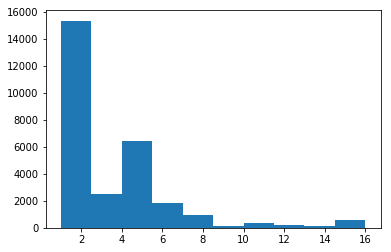

In [40]:
plt.hist(listings_detail["accommodates"])

In [42]:
#  x        type
#  1        0
#  2        1
#  [3, 6]   2
#  [7,10]   3
#  [11,...] 4

def accommodate_map(x):
    if x == 1:
        return 0
    elif x == 2:
        return 1
    elif x >= 3 and x<= 6:
        return 2
    elif x >= 7 and x<= 10:
        return 3
    else:
        return 4

listings_detail["accommodate_type"] = listings_detail["accommodates"].map(accommodate_map) 

In [44]:
cat_vs_label(listings_detail, "accommodate_type", "label")

label              1.0   2.0  3.0  4.0
accommodate_type                      
0                 1087  1347  180   83
1                 4924  6689  755  285
2                 4022  6096  517  141
3                  561   732   46   12
4                  564   397    8    6
 
-------
纵向成分统计
label                  1.0       2.0       3.0       4.0
accommodate_type                                        
1                 0.441298  0.438307  0.501328  0.540797
2                 0.360459  0.399450  0.343293  0.267552
0                 0.097419  0.088264  0.119522  0.157495
3                 0.050278  0.047965  0.030544  0.022770
4                 0.050547  0.026014  0.005312  0.011385
 
-------
横向成分统计
label                  1.0       2.0       3.0       4.0
accommodate_type                                        
0                 0.403040  0.499444  0.066741  0.030775
1                 0.389157  0.528649  0.059670  0.022524
2                 0.373237  0.565702  0.047977  0.013085
3        

/home/yangsi/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/yangsi/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.5505e+04, 2.1300e+03, 6.0600e+02, 1.1000e+02, 7.4000e+01,
        5.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

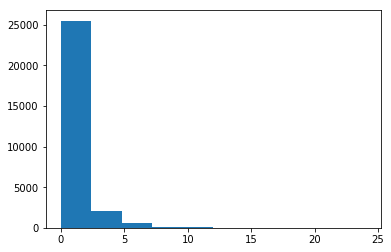

In [45]:
plt.hist(listings_detail["bedrooms"])

In [47]:
#  x        type
#  0        0
#  1        1
#  2        2
#  [3, 5]   3
#  [6,10]   4
#  [11,...] 5

def bedroom_map(x):
    if x == 0:
        return 0
    elif x == 1:
        return 1
    elif x == 2:
        return 2
    elif x >= 3 and x<= 5:
        return 3
    elif x >= 6 and x<= 10:
        return 4
    else:
        return 5

listings_detail["bedroom_type"] = listings_detail["bedrooms"].map(bedroom_map) 

In [48]:
cat_vs_label(listings_detail, "bedroom_type", "label")

label            1.0     2.0     3.0    4.0
bedroom_type                               
0             1111.0   976.0    66.0   14.0
1             6543.0  9490.0  1094.0  430.0
2             2165.0  3282.0   272.0   62.0
3              994.0  1329.0    70.0   18.0
4              328.0   170.0     4.0    3.0
5               17.0    14.0     NaN    NaN
 
-------
纵向成分统计
label              1.0       2.0       3.0       4.0
bedroom_type                                        
1             0.586395  0.621847  0.726428  0.815939
2             0.194031  0.215058  0.180611  0.117647
3             0.089084  0.087085  0.046481  0.034156
0             0.099570  0.063954  0.043825  0.026565
4             0.029396  0.011140  0.002656  0.005693
5             0.001524  0.000917       NaN       NaN
 
-------
横向成分统计
label              1.0       2.0       3.0       4.0
bedroom_type                                        
1             0.372672  0.540525  0.062311  0.024492
2             0.374503  0.56772

 max bathrooms 101.5, min bathrooms 0.0


(array([3.3400e+02, 2.4231e+04, 2.6590e+03, 4.4700e+02, 3.1600e+02,
        1.5800e+02, 9.3000e+01, 7.2000e+01, 9.8000e+01, 1.0000e+01,
        7.0000e+00, 7.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

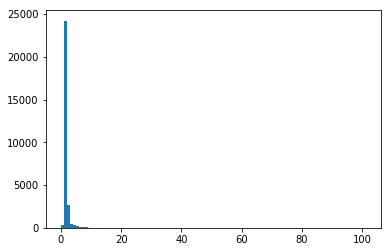

In [54]:
print(" max bathrooms {}, min bathrooms {}".format(max(listings_detail["bathrooms"]),\
                                                   min(listings_detail["bathrooms"])))
plt.hist(listings_detail["bathrooms"], bins = range(0, 102, 1))

In [63]:
#  x        type
#  0        0
#  1        1
#  2        2
#  [3, 10]  3
#  [11,...] 4

def bathroom_map(x):
    if x >= 0 and (x < 3):
        return x
    elif x >= 3 :
        return "more"

listings_detail["bathroom_type"] = listings_detail["bathrooms"].map(bathroom_map) 

In [64]:
cat_vs_label(listings_detail, "bathroom_type", "label")

label           1.0    2.0   3.0  4.0
bathroom_type                        
0.0              44     45     4    5
0.5              75    131    16   14
1.0            9147  12847  1323  448
1.5             143    275    32   16
2.0            1055   1382   109   37
2.5              25     41     6    4
more            666    537    16    3
 
-------
纵向成分统计
label               1.0       2.0       3.0       4.0
bathroom_type                                        
1.0            0.819991  0.841985  0.878486  0.850095
2.0            0.094576  0.090575  0.072377  0.070209
1.5            0.012819  0.018023  0.021248  0.030361
0.5            0.006723  0.008586  0.010624  0.026565
0.0            0.003944  0.002949  0.002656  0.009488
2.5            0.002241  0.002687  0.003984  0.007590
more           0.059704  0.035195  0.010624  0.005693
 
-------
横向成分统计
label               1.0       2.0       3.0       4.0
bathroom_type                                        
0.5            0.317797  0.555

In [74]:
listings_detail["bed_per_person"] = listings_detail.apply(lambda r: r["beds"]/r["accommodates"], axis =1)
listings_detail["bathromms_per_person"] = listings_detail.apply(lambda r: r["bathrooms"]/r["accommodates"], axis =1)
listings_detail["bedrooms_per_person"] = listings_detail.apply(lambda r: r["bedrooms"]/r["accommodates"], axis =1)

(array([2.3907e+04, 4.1480e+03, 1.5400e+02, 7.5000e+01, 7.3000e+01,
        1.9000e+01, 4.2000e+01, 2.0000e+00, 1.2000e+01, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 14 Patch objects>)

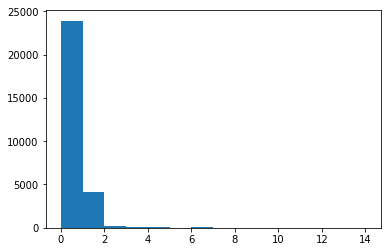

In [83]:
col = "bed_per_person"
min_val = min(listings_detail[col])
max_val = max(listings_detail[col])
min_val = math.floor(min_val)
max_val = math.ceil(max_val)
plt.hist(listings_detail[col], bins = range(min_val, max_val, 1))

In [85]:
for col in ["bed_per_person", "bathromms_per_person", "bedrooms_per_person"]:
    print(listings_detail.groupby(["label"])[col].mean())

label
1.0    0.623321
2.0    0.604621
3.0    0.619061
4.0    0.683099
Name: bed_per_person, dtype: float64
label
1.0    0.470644
2.0    0.458673
3.0    0.493441
4.0    0.524929
Name: bathromms_per_person, dtype: float64
label
1.0    0.466438
2.0    0.468333
3.0    0.500626
4.0    0.542214
Name: bedrooms_per_person, dtype: float64


#### 关于硬件设备

In [6]:
col = "amenities"
listings_detail[col] = listings_detail[col].map(str2list)

In [22]:
count_df_list = []
for label in [1, 2, 3, 4]:
#     print(" ")
#     print("current label: ", label)
    amenities_list = []
    size =  listings_detail[listings_detail["label"] == label].shape[0]
    
    for item in listings_detail[listings_detail["label"] == label]["amenities"].values:
        amenities_list.extend(item)
    # amenities_list = list(set(amenities_list))
    tmp = pd.Series(amenities_list).value_counts(ascending = False)
    tmp = pd.DataFrame(tmp)
    tmp.columns = ["count"]
    tmp["count"] = tmp["count"].map(lambda x: x/size) 
    tmp.columns = ["label_" + str(label)]
    count_df_list.append(tmp)
#     print(" ")

#### 关于硬件设备的保障，差距还是很大的。。。

In [125]:
for i in range(len(count_df_list)):
    if i == 0:
        count_df = count_df_list[i]
    else:
        count_df = pd.merge(count_df, count_df_list[i], left_index = True, right_index = True)


In [127]:
count_df = count_df.sort_values(by=["label_4", "label_3", "label_2", "label_1"], ascending = [False] * 4)
count_df

label_1   label_2   label_3  \
Wifi                                        0.948378  0.978704  0.992032   
Heating                                     0.896487  0.954459  0.974768   
Essentials                                  0.912888  0.961733  0.975432   
Air conditioning                            0.935472  0.958456  0.962815   
Hair dryer                                  0.809823  0.905445  0.965471   
Shampoo                                     0.860100  0.935063  0.963479   
Hangers                                     0.849794  0.913571  0.950199   
Washer                                      0.835275  0.919402  0.950863   
Step-free access                            0.355709  0.607103  0.774900   
Laptop friendly workspace                   0.722352  0.796213  0.871182   
Kitchen                                     0.771106  0.852369  0.877158   
Hot water                                   0.601900  0.684228  0.760956   
TV                                          0.791360  0.783107  0.770916   
Elevator                                    0.582542  0.632396  0.673307   
Wide doorway                                0.317978  0.506913  0.599602   
Iron                                        0.205592  0.340476  0.494024   
Self check-in                               0.166607  0.408951  0.541169   
Lock on bedroom door                        0.442194  0.484634  0.511952   
Smoke detector                              0.436010  0.459210  0.514608   
Refrigerator                                0.165621  0.340476  0.456839   
Long term stays allowed                     0.253719  0.439028  0.537849   
Dishes and silverware                       0.132192  0.291134  0.412351   
Fire extinguisher                           0.497491  0.471070  0.463479   
Bed linens                                  0.148593  0.279929  0.389110   
Paid parking on premises                    0.113461  0.295656  0.413015   
Cooking basics                              0.113192  0.251556  0.362550   
Luggage dropoff allowed                     0.189012  0.314724  0.375830   
Carbon monoxide detector                    0.235078  0.283206  0.361222   
First aid kit                               0.229701  0.276587  0.301461   
Cable TV                                    0.134433  0.226787  0.310757   
Microwave                                   0.093655  0.197628  0.291501   
Stove                                       0.112296  0.222004  0.328021   
Paid parking off premises                   0.122782  0.277046  0.333333   
Extra pillows and blankets                  0.073848  0.166765  0.265604   
Private entrance                            0.399175  0.403185  0.344622   
Family/kid friendly                         0.106650  0.194090  0.265604   
Well-lit path to entrance                   0.120093  0.206867  0.254316   
Internet                                    0.033519  0.083874  0.154714   
Ethernet connection                         0.078957  0.171286  0.243692   
Handheld shower head                        0.113103  0.189372  0.235724   
translation missing: en.hosting_amenity_50  0.013354  0.046589  0.124834   
Free street parking                         0.119466  0.217482  0.259628   
Smart lock                                  0.044184  0.150580  0.231076   
Wide hallway clearance                      0.108801  0.185833  0.216467   
Flat path to front door                     0.097419  0.166437  0.197875   
Free parking on premises                    0.436996  0.301946  0.226428   
Doorman                                     0.064259  0.106481  0.146082   
Private living room                         0.171536  0.189830  0.193891   
Room-darkening shades                       0.070263  0.121027  0.170651   
translation missing: en.hosting_amenity_49  0.008962  0.027849  0.075697   
Wide entryway                               0.087919  0.134722  0.167331   
Safety card                                 0.060943  0.103728  0.142762   
Keypad           

In [ ]:
count_df["equip"] = count_df.index
count_df = count_df.reset_index(drop = True)
count_df = count_df.set_index(["equip"])
count_df = count_df.stack().unstack(["equip"])

In [123]:
count_df

equip        Wifi  Air conditioning  Essentials   Heating   Shampoo   Hangers  \
label_1  0.948378          0.935472    0.912888  0.896487  0.860100  0.849794   
label_2  0.978704          0.958456    0.961733  0.954459  0.935063  0.913571   
label_3  0.992032          0.962815    0.975432  0.974768  0.963479  0.950199   
label_4  0.998102          0.973435    0.979127  0.981025  0.946869  0.943074   

equip      Washer  Hair dryer        TV   Kitchen  ...  Kitchenette  \
label_1  0.835275    0.809823  0.791360  0.771106  ...     0.000717   
label_2  0.919402    0.905445  0.783107  0.852369  ...     0.004914   
label_3  0.950863    0.965471  0.770916  0.877158  ...     0.005976   
label_4  0.941176    0.954459  0.741935  0.874763  ...     0.005693   

equip    Hot water kettle  Bedroom comforts  Toilet paper  Body soap  \
label_1          0.000358          0.000090      0.000090   0.000090   
label_2          0.007077          0.006028      0.005766   0.005766   
label_3          0.011288          0.008632      0.008632   0.008632   
label_4          0.043643          0.034156      0.032258   0.032258   

equip    Bath towel  Projector and screen  Bathroom essentials   Balcony  \
label_1    0.000090              0.000090             0.000090  0.000090   
label_2    0.005766              0.000590             0.006028  0.000590   
label_3    0.008632              0.001328             0.008632  0.001992   
label_4    0.032258              0.007590             0.034156  0.005693   

equip    Standing valet  
label_1        0.000090  
label_2        0.000852  
label_3        0.001328  
label_4        0.011385  

[4 rows x 124 columns]

In [124]:
save_dir = "result" + os.sep + "eq_vs_label.xlsx"
count_df.to_excel(save_dir)

### 关于价格的影响

In [26]:
price_col = ["price", "weekly_price", "monthly_price",
            "security_deposit", "cleaning_fee"]

In [29]:
listings_detail["price"] = listings_detail["price"].map(str2price)

In [36]:
for col in ["weekly_price", "monthly_price", "security_deposit", "cleaning_fee"]:
    listings_detail[col] = listings_detail[col].map(str2price)

In [30]:
listings_detail.groupby(["label"])["price"].agg({"mean", "max", "min", "median"})

min  median      max        mean
label                                   
1.0     0.0   396.0  67909.0  743.140079
2.0     0.0   382.0  68983.0  544.843064
3.0    67.0   329.0   9998.0  390.151394
4.0    54.0   255.0   9998.0  371.123340

In [41]:
def weekly_off(r):
    if pd.isnull(r["weekly_price"]):
        return 1
    else:
        return r["weekly_price"]/(r["price"] * 7)

listings_detail["weekly_off"] = listings_detail.apply(lambda r: weekly_off(r), axis = 1)

In [43]:
listings_detail.groupby(["label"])["weekly_off"].agg({"mean", "max", "min", "median"})

min  median       max      mean
label                                      
1.0    0.093985     1.0  1.399417  0.999091
2.0    0.029821     1.0  8.484916  0.997764
3.0    0.119048     1.0  1.453018  0.992248
4.0    0.029821     1.0  3.560781  0.991518

#### 爬虫出错， 访问该页面： https://www.airbnb.com/rooms/6086159?source_impression_id=p3_1584951324_c9Egfm55Y%2FCvrv%2F8
人民币价格 580，却改为美元价格 590

In [58]:
# print(listings_detail[listings_detail["weekly_off"] < 0.04])

### 关于评价

In [59]:
review_col = ['number_of_reviews', 'number_of_reviews_ltm',
             'first_review', 'last_review', 'review_scores_rating',
             'review_scores_accuracy', 'review_scores_cleanliness',
             'review_scores_checkin',  'review_scores_communication',
             'review_scores_location', 'review_scores_value',
             'reviews_per_month']

In [71]:
listings_detail.groupby(["label"])["number_of_reviews"].agg({"max", "min", "mean", "median

min  median  max       mean
label                             
1.0      0       0    0   0.000000
2.0      1       3  284   8.426709
3.0      2      18  240  27.482072
4.0      4      48  322  60.931689

In [74]:
for col in ['review_scores_accuracy', 'review_scores_cleanliness',
             'review_scores_checkin',  'review_scores_communication',
             'review_scores_location', 'review_scores_value']:
    print(" ")
    print("current review column ", col)
    tmp = listings_detail.groupby(["label"])[col].agg({"max", "min", "mean", "median"})
    print(tmp)
    print(" ")

 
current review column  review_scores_accuracy
       min  median   max      mean
label                             
1.0    6.0    10.0  10.0  9.000000
2.0    2.0    10.0  10.0  9.652689
3.0    2.0    10.0  10.0  9.882392
4.0    9.0    10.0  10.0  9.914611
 
 
current review column  review_scores_cleanliness
       min  median   max      mean
label                             
1.0    2.0     8.0  10.0  7.500000
2.0    2.0    10.0  10.0  9.479101
3.0    2.0    10.0  10.0  9.708970
4.0    7.0    10.0  10.0  9.747628
 
 
current review column  review_scores_checkin
       min  median   max      mean
label                             
1.0    6.0    10.0  10.0  9.500000
2.0    2.0    10.0  10.0  9.730046
3.0    2.0    10.0  10.0  9.932846
4.0    8.0    10.0  10.0  9.946869
 
 
current review column  review_scores_communication
       min  median   max      mean
label                             
1.0    6.0    10.0  10.0  9.500000
2.0    2.0    10.0  10.0  9.781166
3.0    2.0    10.0  10.0 

In [75]:
cat_vs_label(listings_detail,'review_scores_accuracy', 'label' )

label                   1.0      2.0     3.0    4.0
review_scores_accuracy                             
2.0                     NaN     85.0     1.0    NaN
4.0                     NaN     49.0     NaN    NaN
5.0                     NaN     19.0     NaN    NaN
6.0                     2.0    176.0     NaN    NaN
7.0                     NaN    116.0     1.0    NaN
8.0                     NaN    631.0     3.0    NaN
9.0                     NaN   1777.0   160.0   45.0
10.0                    6.0  12004.0  1340.0  482.0
 
-------
纵向成分统计
label                    1.0       2.0       3.0       4.0
review_scores_accuracy                                    
10.0                    0.75  0.807969  0.890365  0.914611
9.0                      NaN  0.119607  0.106312  0.085389
8.0                      NaN  0.042472  0.001993       NaN
7.0                      NaN  0.007808  0.000664       NaN
2.0                      NaN  0.005721  0.000664       NaN
6.0                     0.25  0.011846       NaN  

In [76]:
cat_vs_label(listings_detail,'review_scores_cleanliness', 'label' )

label                      1.0      2.0     3.0    4.0
review_scores_cleanliness                             
2.0                        1.0     81.0     1.0    NaN
3.0                        NaN      2.0     NaN    NaN
4.0                        1.0     72.0     NaN    NaN
5.0                        NaN     25.0     NaN    NaN
6.0                        NaN    228.0     NaN    NaN
7.0                        NaN    174.0     2.0    1.0
8.0                        3.0   1084.0    22.0    5.0
9.0                        NaN   2918.0   380.0  120.0
10.0                       3.0  10273.0  1100.0  401.0
 
-------
纵向成分统计
label                        1.0       2.0       3.0       4.0
review_scores_cleanliness                                     
10.0                       0.375  0.691459  0.730897  0.760911
9.0                          NaN  0.196406  0.252492  0.227704
8.0                        0.375  0.072962  0.014618  0.009488
7.0                          NaN  0.011712  0.001329  0.001898


In [77]:
cat_vs_label(listings_detail,'review_scores_checkin', 'label' )

label                  1.0      2.0     3.0    4.0
review_scores_checkin                             
2.0                    NaN     80.0     1.0    NaN
4.0                    NaN     34.0     NaN    NaN
5.0                    NaN      6.0     NaN    NaN
6.0                    1.0    140.0     NaN    NaN
7.0                    NaN     86.0     NaN    NaN
8.0                    NaN    482.0     NaN    1.0
9.0                    NaN   1352.0    93.0   26.0
10.0                   7.0  12667.0  1410.0  500.0
 
-------
纵向成分统计
label                    1.0       2.0       3.0       4.0
review_scores_checkin                                     
10.0                   0.875  0.853169  0.937500  0.948767
9.0                      NaN  0.091062  0.061835  0.049336
8.0                      NaN  0.032464       NaN  0.001898
2.0                      NaN  0.005388  0.000665       NaN
6.0                    0.125  0.009430       NaN       NaN
7.0                      NaN  0.005792       NaN       NaN
4

In [78]:
cat_vs_label(listings_detail,'review_scores_communication', 'label' )

label                        1.0      2.0     3.0    4.0
review_scores_communication                             
2.0                          NaN     68.0     1.0    NaN
4.0                          NaN     29.0     NaN    NaN
5.0                          NaN      4.0     NaN    NaN
6.0                          1.0    121.0     NaN    NaN
7.0                          NaN     73.0     1.0    NaN
8.0                          NaN    383.0     5.0    1.0
9.0                          NaN   1044.0    80.0   17.0
10.0                         7.0  13134.0  1418.0  509.0
 
-------
纵向成分统计
label                          1.0       2.0       3.0       4.0
review_scores_communication                                     
10.0                         0.875  0.884087  0.942193  0.965844
9.0                            NaN  0.070275  0.053156  0.032258
8.0                            NaN  0.025781  0.003322  0.001898
7.0                            NaN  0.004914  0.000664       NaN
2.0                    

In [79]:
cat_vs_label(listings_detail,'review_scores_location', 'label' )

label                   1.0      2.0     3.0    4.0
review_scores_location                             
2.0                     NaN     53.0     1.0    NaN
4.0                     NaN     35.0     NaN    NaN
5.0                     NaN      7.0     NaN    NaN
6.0                     1.0    200.0     NaN    NaN
7.0                     NaN    123.0     1.0    NaN
8.0                     1.0    861.0    14.0    2.0
9.0                     NaN   2389.0   263.0   85.0
10.0                    6.0  11167.0  1225.0  440.0
 
-------
纵向成分统计
label                     1.0       2.0       3.0       4.0
review_scores_location                                     
10.0                    0.750  0.752747  0.814495  0.834915
9.0                       NaN  0.161038  0.174867  0.161290
8.0                     0.125  0.058038  0.009309  0.003795
7.0                       NaN  0.008291  0.000665       NaN
2.0                       NaN  0.003573  0.000665       NaN
6.0                     0.125  0.013482    

In [80]:
cat_vs_label(listings_detail,'review_scores_value', 'label' )

label                1.0      2.0     3.0    4.0
review_scores_value                             
2.0                  1.0     91.0     1.0    NaN
3.0                  NaN      1.0     NaN    NaN
4.0                  NaN     55.0     NaN    NaN
5.0                  NaN     20.0     NaN    NaN
6.0                  1.0    237.0     NaN    NaN
7.0                  NaN    166.0     2.0    NaN
8.0                  1.0   1068.0    12.0    2.0
9.0                  NaN   3036.0   350.0   92.0
10.0                 5.0  10161.0  1139.0  433.0
 
-------
纵向成分统计
label                  1.0       2.0       3.0       4.0
review_scores_value                                     
10.0                 0.625  0.684934  0.757314  0.821632
9.0                    NaN  0.204651  0.232713  0.174573
8.0                  0.125  0.071992  0.007979  0.003795
7.0                    NaN  0.011190  0.001330       NaN
2.0                  0.125  0.006134  0.000665       NaN
6.0                  0.125  0.015976       Na

### 关于房东的要求方面

In [81]:
guest_require_col = ["license", "requires_license",
                    "jurisdiction_names",
                    "instant_bookable",
                    "is_business_travel_ready",
                    "cancellation_policy",
                    "require_guest_profile_picture",
                    "require_guest_phone_verification"]

In [82]:
cat_vs_label(listings_detail, "cancellation_policy", "label")

label                         1.0   2.0  3.0  4.0
cancellation_policy                              
flexible                     7645  7041  493  141
moderate                     1813  5097  663  234
strict_14_with_grace_period  1700  3123  350  152
 
-------
纵向成分统计
label                             1.0       2.0       3.0       4.0
cancellation_policy                                                
moderate                     0.162484  0.333989  0.440239  0.444023
strict_14_with_grace_period  0.152357  0.204639  0.232404  0.288425
flexible                     0.685159  0.461372  0.327357  0.267552
 
-------
横向成分统计
label                             1.0       2.0       3.0       4.0
cancellation_policy                                                
moderate                     0.232227  0.652876  0.084924  0.029973
strict_14_with_grace_period  0.319249  0.586479  0.065728  0.028545
flexible                     0.499021  0.459595  0.032180  0.009204


In [83]:
cat_vs_label(listings_detail, "instant_bookable", "label")

label              1.0    2.0  3.0  4.0
instant_bookable                       
f                 3967   5095  534  210
t                 7191  10166  972  317
 
-------
纵向成分统计
label                 1.0       2.0       3.0       4.0
instant_bookable                                       
t                 0.64447  0.666142  0.645418  0.601518
f                 0.35553  0.333858  0.354582  0.398482
 
-------
横向成分统计
label                  1.0       2.0       3.0       4.0
instant_bookable                                        
f                 0.404548  0.519580  0.054456  0.021415
t                 0.385659  0.545211  0.052129  0.017001


In [85]:
cat_vs_label(listings_detail, "require_guest_phone_verification", "label")

label                               1.0    2.0   3.0  4.0
require_guest_phone_verification                         
f                                 11153  15235  1502  520
t                                     5     26     4    7
 
-------
纵向成分统计
label                                  1.0       2.0       3.0       4.0
require_guest_phone_verification                                        
f                                 0.999552  0.998296  0.997344  0.986717
t                                 0.000448  0.001704  0.002656  0.013283
 
-------
横向成分统计
label                                  1.0       2.0       3.0       4.0
require_guest_phone_verification                                        
t                                 0.119048  0.619048  0.095238  0.166667
f                                 0.392573  0.536255  0.052869  0.018303
